In [1]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from tqdm import tqdm


class HopfieldNetwork:

    def __init__(self, train_dataset: list):
        self.train_dataset = train_dataset
        self.num_training = len(self.train_dataset)
        self.num_neurons = len(self.train_dataset[0])
        self.weight = self.create_weight_table()

    def create_weight_table(self):

        w_table = np.zeros(shape=(self.num_neurons, self.num_neurons))

        # the Hebb rule
        for pattern in self.train_dataset:

            pattern_w = np.zeros(shape=(self.num_neurons, self.num_neurons))

            for i in range(self.num_neurons):
                for j in range(self.num_neurons):
                    pattern_w[i][j] = pattern[i] * pattern[j] / self.num_neurons

            w_table += pattern_w

        return w_table

    def activate(self, vector, max_iter=50):
        iter_num = 0

        new_vector = vector

        for iter_num in range(max_iter):

            prev_vector = new_vector

            new_vector = self._sgn_multiply(prev_vector)

            if (prev_vector == new_vector).all():
                return iter_num, new_vector

        return iter_num, new_vector

    def reconstructed_time_per_noise(self, noise_amount, random_change=True):

        noises_vector = self._get_noise_vector(noise_amount, random_change)

        time, reconstructed_vector = self.activate(noises_vector)

        return time

    def _sgn_multiply(self, vector):

        # multiply the weight matrix with the chosen pattern
        new_vector = self.weight.dot(vector)

        # get the sign vector
        return np.sign(new_vector)

    def _is_fixed_point(self, pattern, noises_pattern, max_iter=50):

        curr_vector = noises_pattern

        for iteration in range(max_iter):

            curr_vector = self._sgn_multiply(curr_vector)

            if np.array_equal(pattern, curr_vector):
                return True

        return False

    def get_capacity(self, noise_amount=0.0, max_iter=20):

        successes_count = 0

        for pattern in self.train_dataset:

            noises_pattern = self._get_noise_vector(pattern, noise_amount)

            time, output_vector = self.activate(vector=noises_pattern, max_iter=max_iter)

            if (output_vector == pattern).all():
                successes_count += 1

        return successes_count / self.num_training

    def get_init_vector(self, from_data=False, train_data_index=-1, random_indexes=True, noise_amount=0):

        if from_data is False:
            return HopfieldNetwork.get_random_init_vector(self.num_neurons)

        pattern_num = train_data_index

        if pattern_num < 0:
            # random index
            pattern_num = np.random.randint(0, self.num_training)

        init_vector = self.train_dataset[pattern_num]
        return HopfieldNetwork._get_noise_vector(vector=init_vector, random_indexes=random_indexes,
                                                 noise_amount=noise_amount)

    @staticmethod
    def get_random_init_vector(length=100):
        return np.random.choice(a=[-1, 1], size=[length]).tolist()

    @staticmethod
    def _get_noise_vector(vector, noise_amount: float, random_indexes=True):

        noises_vector = vector

        length = len(vector)

        if random_indexes:
            indexes_to_change = np.random.choice(a=range(length),
                                                 size=int(noise_amount * length)).tolist()
        else:
            indexes_to_change = np.arange(0, int(noise_amount * length))

        # change chosen bits
        for i in indexes_to_change:
            noises_vector[i] &= -1

        return noises_vector


In [2]:

class PlotHopfieldNetwork:

    @staticmethod
    def capacity_average_to_patterns_num(nmsit_percent=0.0):

        fig, ax = plt.subplots(figsize=(12, 7))

        PlotHopfieldNetwork._add_capacity_average_to_patterns_amount_plot(axis=ax, nmsit_percent=nmsit_percent)

        # add percent to y axis
        ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

        ax.set_xlabel('Pattern Number')
        ax.set_ylabel('Capacity')
        ax.set_title('Capacity to Pattern Amount')
        plt.grid()
        plt.show()

    @staticmethod
    def time_average_to_patterns_num():

        fig, ax = plt.subplots(figsize=(12, 7))

        PlotHopfieldNetwork._add_time_average_to_patterns_num_plot(ax,
                                                                   init_calculator_argvs={'from_data': False},
                                                                   label="random init vector")
        
        PlotHopfieldNetwork._add_time_average_to_patterns_num_plot(ax,
                                                                   init_calculator_argvs={'from_data': False},
                                                                   label="vector from train data")

        ax.set_ylabel('Average Time')
        ax.set_xlabel('Pattern Number')
        ax.set_title('Restorations Time to Pattern Amount')
        plt.legend()
        plt.show()


    @staticmethod
    def _add_time_average_to_patterns_num_plot(axis, init_calculator_argvs: dict, label=""):

        iter_amount = 50

        # different sizes to train data
        x_vector = range(1, 40, 5)

        # zeros matrix for restoration time
        restorations_time = np.zeros((len(x_vector), iter_amount))

        for iter_num in tqdm(zip(range(iter_amount))):

            for i, patterns_amount in zip(range(len(x_vector)), x_vector):
                train_data = np.random.choice(a=[-1, 1], size=[patterns_amount, 100]).tolist()

                model = HopfieldNetwork(train_data)

                init_vector = model.get_init_vector(**init_calculator_argvs)

                time, result_v = model.activate(init_vector)

                restorations_time[i][iter_num] = time

        y_vector = np.average(restorations_time, axis=1)

        axis.plot(x_vector, y_vector, label=label)

    @staticmethod
    def _add_capacity_average_to_patterns_amount_plot(axis, noise=0, nmsit_percent=0.0):

        iter_amount = 5

        # patterns amount's vector
        x_vector = range(1, 30, 1)

        # zeros capacity's matrix
        capacities = np.zeros((len(x_vector), iter_amount))

        for iter_num in tqdm(range(iter_amount)):
            for i, patterns_amount in zip(range(len(x_vector)), x_vector):
                if nmsit_percent > 0:
                    train_data, labels_data = NMISTHandler.get_reduce_nmist(nmsit_percent)
                    train_data = NMISTHandler.encode_binary_data(train_data)[:patterns_amount]
                else:
                    train_data = np.random.choice(a=[-1, 1], size=[patterns_amount, 100]).tolist()

                model = HopfieldNetwork(train_data)

                capacities[i][iter_num] = model.get_capacity(noise, max_iter=50)

        # get the average of iteration's capacities
        y_vector = np.average(capacities, axis=1)

        axis.plot(x_vector, y_vector, label=str(noise))

    @staticmethod
    def capacity_average_to_patterns_amounts_for_different_noises(nmsit=0.0):

        fig, ax = plt.subplots(figsize=(12, 7))

        noises_list = np.arange(0, 41, 10) / 100
        for noise_amount in tqdm(noises_list, desc="outer loop"):
            PlotHopfieldNetwork._add_capacity_average_to_patterns_amount_plot(ax, noise_amount, nmsit_percent=nmsit)

        # add percent to y axis
        ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

        ax.set_xlabel('Pattern Number')
        ax.set_ylabel('Capacity')
        ax.set_title('Capacity to Patterns Amount for Different noise prcent')

        plt.legend()
        plt.show()

    @staticmethod
    def time_average_to_patterns_num_different_noises_calculators():

        fig, ax = plt.subplots(figsize=(12, 7))
        fig, bx = plt.subplots(figsize=(12, 7))

        PlotHopfieldNetwork.capacity_avreage_to_patterns_amount_different_init_chous(ax, bx)

        ax.set_ylabel('Average Time')
        bx.set_ylabel('Average Time')

        ax.set_xlabel('Pattern Number')
        bx.set_xlabel('Pattern Number')

        ax.set_title('Restorations Time to Pattern Amount Deterministic Noise')
        bx.set_title('Restorations Time to Pattern Amount Non-deterministic Noise')

        plt.legend()
        plt.show()

100%|██████████| 5/5 [00:17<00:00,  3.53s/it]


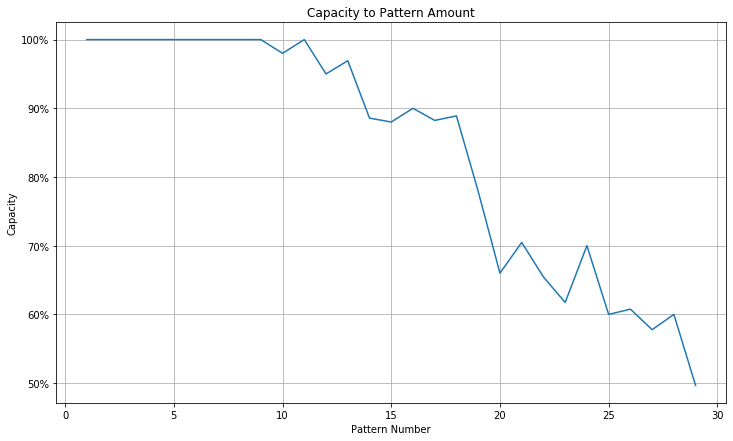

In [3]:
PlotHopfieldNetwork.capacity_average_to_patterns_num()

50it [00:55,  1.11s/it]
50it [00:56,  1.06s/it]


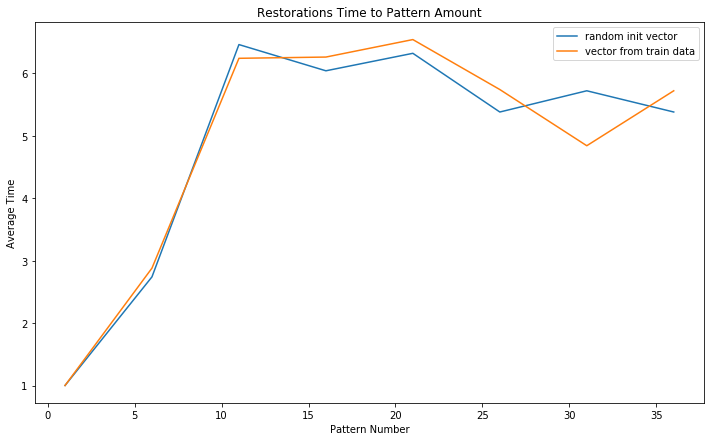

In [4]:
PlotHopfieldNetwork.time_average_to_patterns_num()

outer loop: 100%|██████████| 5/5 [01:39<00:00, 19.62s/it]


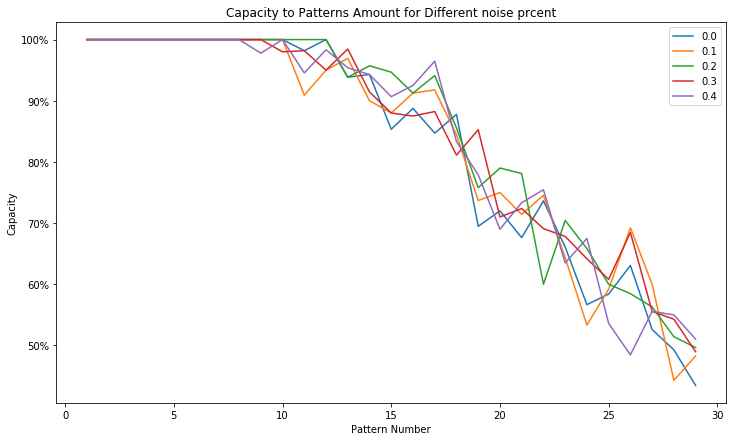

In [5]:
PlotHopfieldNetwork.capacity_average_to_patterns_amounts_for_different_noises()